# K-Means: `Evaluating Cluster Quality`

### Loading Libraries

In [11]:
# Numerical Computing
import numpy as np
from numpy.random import uniform, seed

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Warnings
import warnings

# Scikit-Learn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# IDisplay
from IPython import display

# Time
from time import sleep

In [2]:
seed(42)

sns.set_style('white')

warnings.filterwarnings('ignore')

In [3]:
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 
                                        'medium green', 
                                        'pale red']))

In [ ]:
cmap = ListedColormap(sns.color_palette('Paired', 10))

### 2-D Cluster Demo

In [4]:
def sample_clusters(n_points=500,
                    n_dimensions=2,
                    n_clusters=5,
                    cluster_std=1):
    return make_blobs(n_samples=n_points,
                      n_features=n_dimensions,
                      centers=n_clusters,
                      cluster_std=cluster_std,
                      random_state=42)

### Evaluating Number of Clusters using Inertia

In [5]:
def inertia_plot_update(inertias, ax, delay=1):
    inertias.plot(color='k',
                  lw=1,
                  title='Inertia',
                  ax=ax,
                  xlim=(inertias.index[0], inertias.index[-1]),
                  ylim=(0, inertias.max()))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

In [6]:
def plot_kmeans_result(data, labels, centroids,
                       assignments, ncluster, Z, ax):

    # plot data
    ax.scatter(*data.T, c=labels, s=20, cmap=cmap)

    # plot cluster centers
    ax.scatter(*centroids.T,
               marker='o',
               c='w',
               s=200,
               edgecolor='k',
               zorder=9)

    for i, c in enumerate(centroids):
        ax.scatter(*c,
                   marker=f'${i}$',
                   s=50,
                   edgecolor=['k'],
                   zorder=10)
        xy = pd.DataFrame(data[assignments == i],
                          columns=['x', 'y']).assign(cx=c[0],
                                                     cy=c[1])

        ax.plot(xy[['x', 'cx']].T.values,
                xy[['y', 'cy']].T.values,
                ls='--',
                color='k',
                lw=0.5)

    # plot voronoi
    ax.imshow(Z, interpolation='nearest',
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=cmap,
              aspect='auto',
              origin='lower',
              alpha=.2)
    ax.set_title(f'Number of Clusters: {ncluster}')
    plt.tight_layout()

#### Running Elbow Experiment

In [7]:
n_clusters, max_clusters = 4, 7

cluster_list = list(range(1, max_clusters + 1))

inertias = pd.Series(index=cluster_list)

In [8]:
data, labels = sample_clusters(n_clusters=n_clusters)

x, y = data.T

In [9]:
xx, yy = np.meshgrid(np.arange(x.min() - 1, x.max() + 1, .01), 
                     np.arange(y.min() - 1, y.max() + 1, .01))

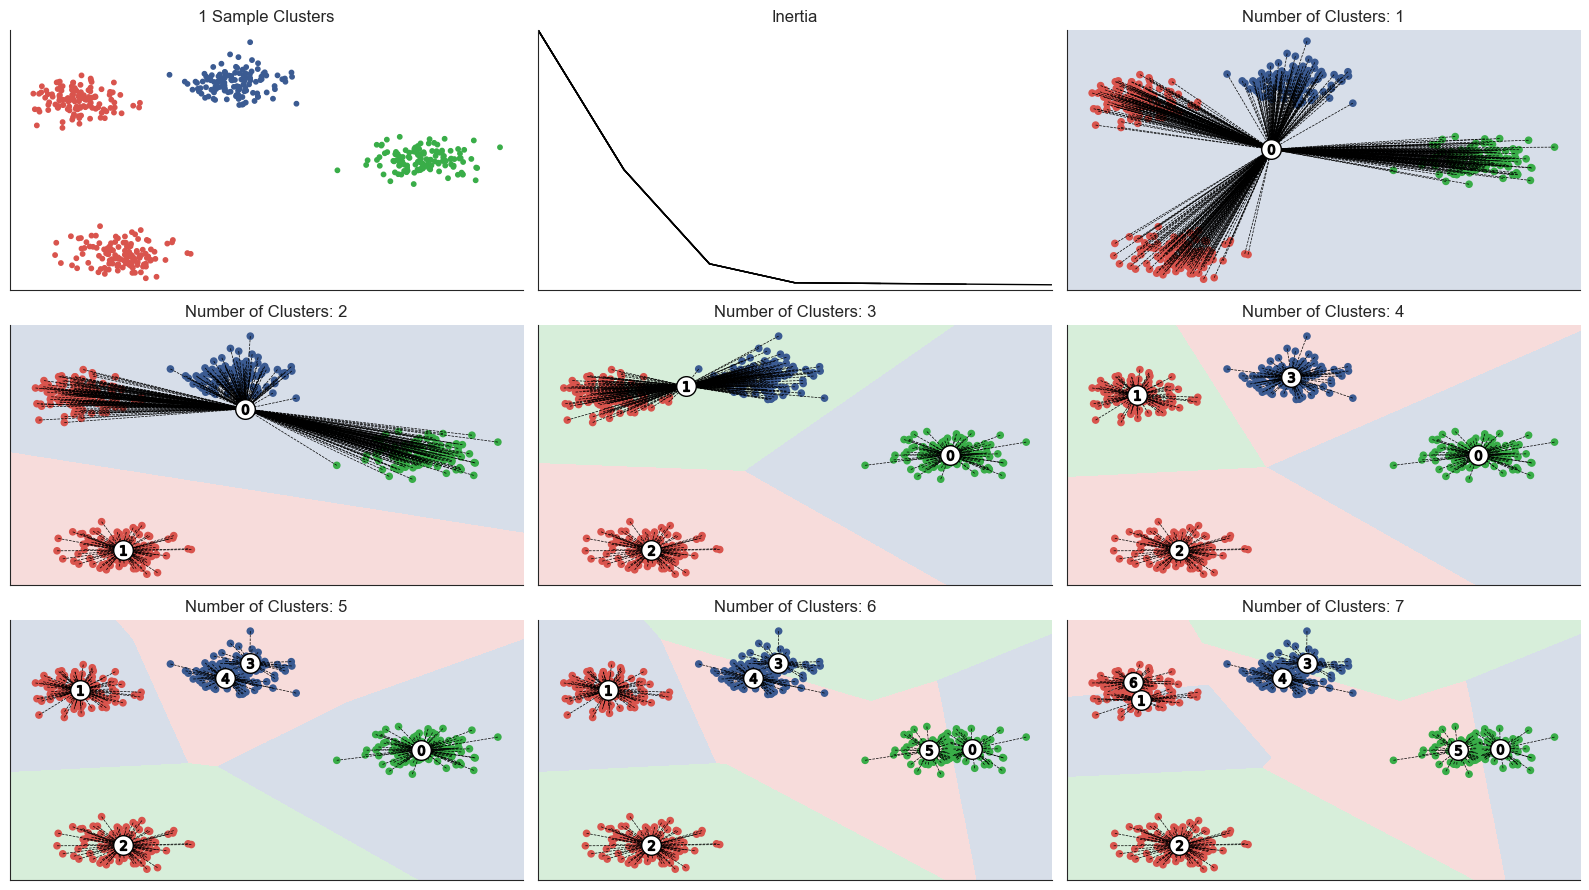

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(16, 9))
axes = np.array(axes).flatten()

# Plot Sample Data
axes[0].scatter(x, y, 
                c=labels, s=10, 
                cmap=cmap)
axes[0].set_title('{} Sample Clusters'.format(n_clusters))
for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine();


for c, n_clusters in enumerate(range(1, max_clusters + 1), 2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    centroids, assignments, inertia = kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_
    inertias[n_clusters] = inertia
    inertia_plot_update(inertias, axes[1])
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plot_kmeans_result(data, labels, centroids, assignments,  n_clusters, Z, axes[c])
fig.tight_layout()

plt.show()

### Evaluating The Silhouette Score

In [13]:
def plot_silhouette(values, y_lower, i, n_cluster, ax):
    cluster_size = values.shape[0]
    y_upper = y_lower + cluster_size

    color = plt.cm.viridis(i / n_cluster)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, values,
                facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10
    return y_lower

In [14]:
def format_silhouette_plot(ax):
    ax.set_title("Silhouette Plot")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=silhouette_avg, 
               color='red', 
               linestyle='--', 
               lw=1)
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [15]:
def plot_final_assignments(x, y, centroids, 
                           assignments, n_cluster, ax):
    c = plt.cm.viridis(assignments / n_cluster)
    ax.scatter(x, y, marker='.', s=30, 
               lw=0, alpha=0.7, c=c, edgecolor='k')
    ax.scatter(*centroids.T, marker='o',  
               c='w', s=200, edgecolor='k')
    for i, c in enumerate(centroids):
        ax.scatter(*c, marker='${}$'.format(i), 
                   s=50, edgecolor='k')

    ax.set_title('{} Clusters'.format(n_cluster))

In [16]:
n_clusters = 4

max_clusters = 7

cluster_list = list(range(1, max_clusters + 1))

inertias = pd.Series(index=cluster_list)

In [17]:
data, labels = sample_clusters(n_clusters=n_clusters)

x, y = data.T

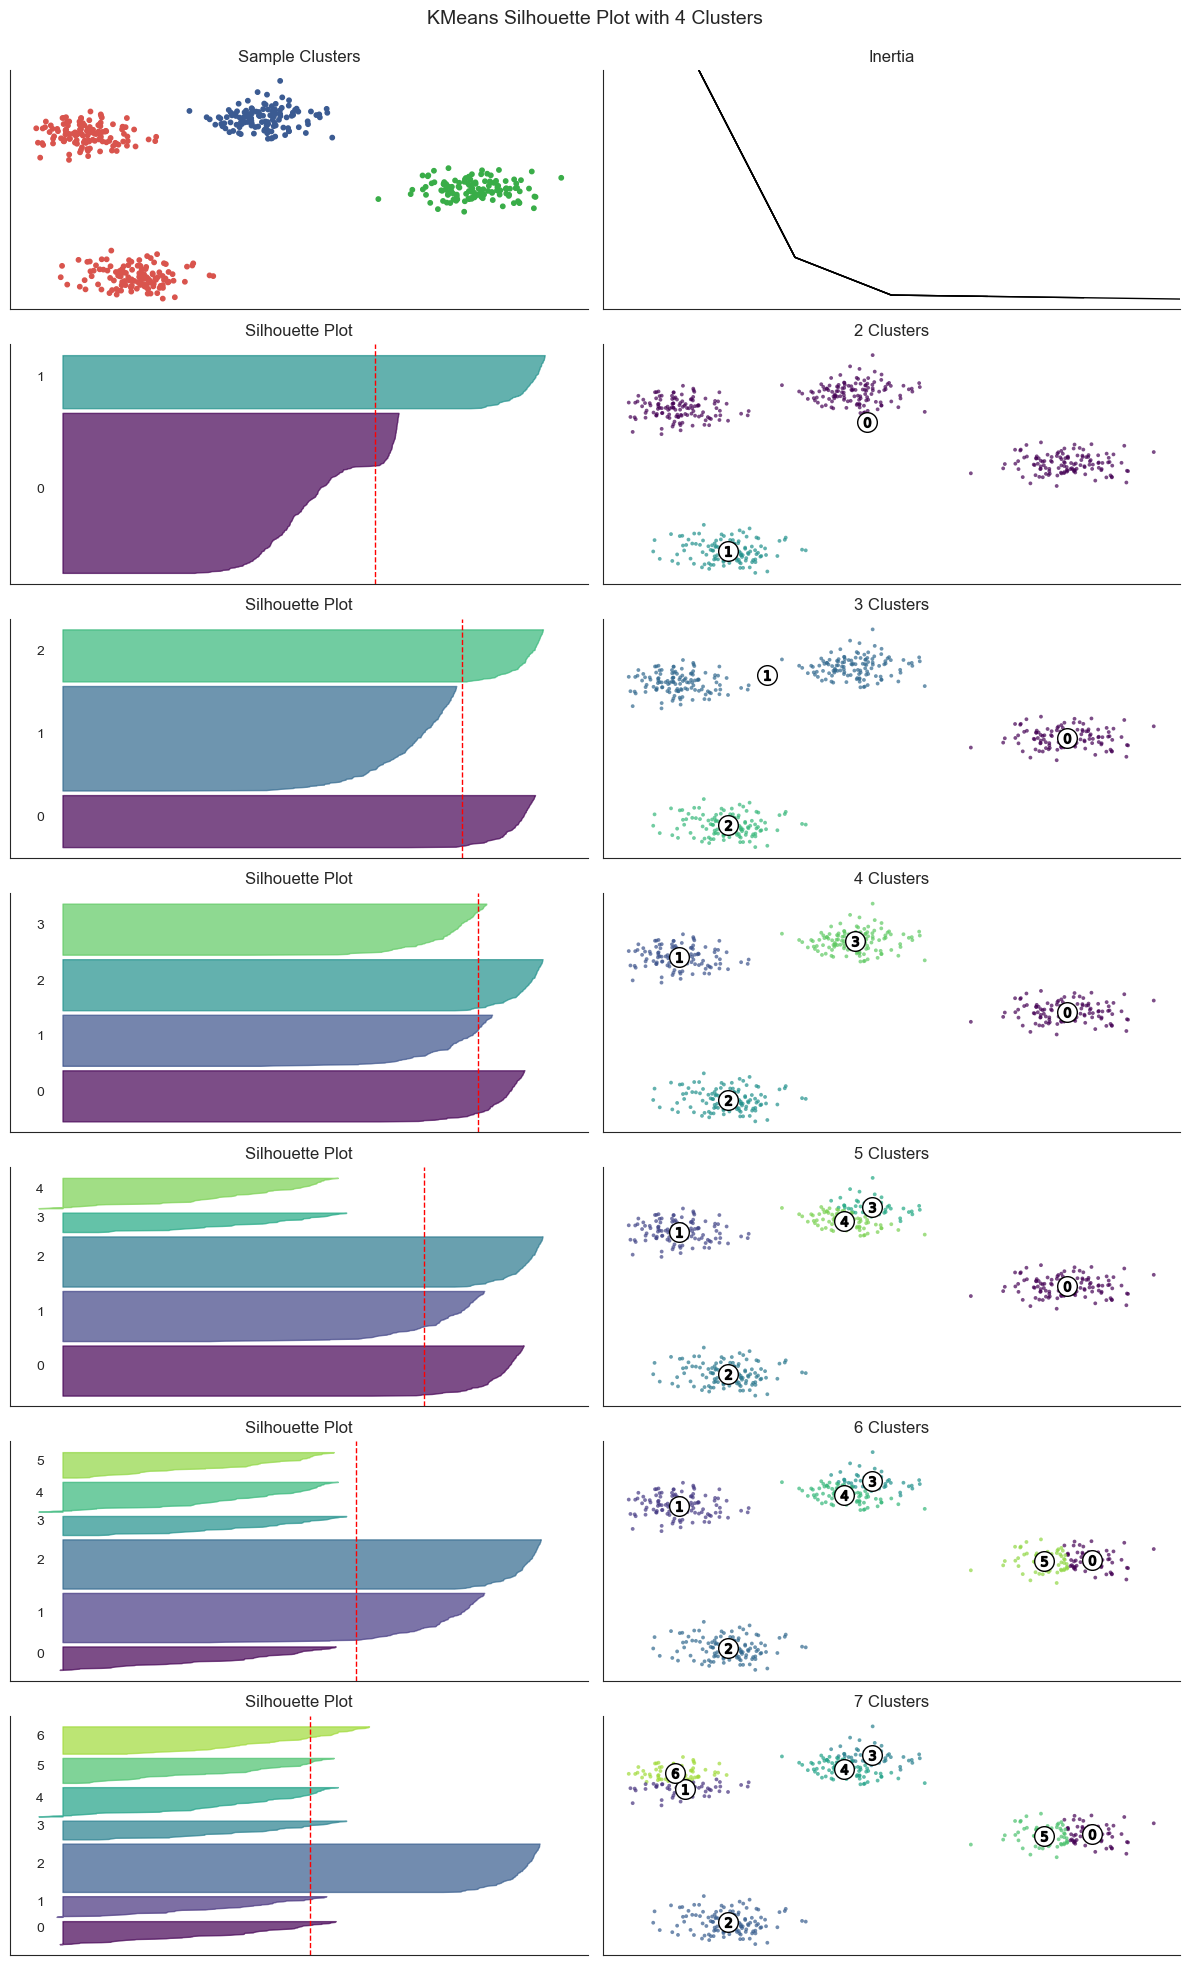

In [19]:
fig, axes = plt.subplots(ncols=2,
                         nrows=max_clusters,
                         figsize=(12, 20))

axes[0][0].scatter(x, y, c=labels, s=10, cmap=cmap)
axes[0][0].set_title('Sample Clusters')

for i in range(max_clusters):
    for j in [0, 1]:
        axes[i][j].axes.get_xaxis().set_visible(False)
        axes[i][j].axes.get_yaxis().set_visible(False)
sns.despine()

for row, n_cluster in enumerate(range(2, max_clusters + 1), 1):
    kmeans = KMeans(n_clusters=n_cluster,
                    random_state=42).fit(data)

    centroids, assignments, inertia = (kmeans.cluster_centers_,
                                       kmeans.labels_,
                                       kmeans.inertia_)
    inertias[n_cluster] = inertia
    inertia_plot_update(inertias, axes[0][1])

    silhouette_avg = silhouette_score(data, assignments)
    silhouette_values = silhouette_samples(data, assignments)
    silhouette_plot, cluster_plot = axes[row]

    y_lower = 10
    for i in range(n_cluster):
        y_lower = plot_silhouette(np.sort(silhouette_values[assignments == i]),
                                  y_lower,
                                  i,
                                  n_cluster,
                                  silhouette_plot)
    format_silhouette_plot(silhouette_plot)
    plot_final_assignments(x, y, centroids, assignments,
                           n_cluster, cluster_plot)
    fig.tight_layout()

fig.suptitle(f'KMeans Silhouette Plot with {n_clusters} Clusters',
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.95)
plt.show()